In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
from torchvision import datasets, transforms


In [ ]:
drive.mount('/content/drive')
#create a public google drive folder here
# link: https://drive.google.com/drive/folders/1FG4BFlGGv5IjNNbKp8fi7VU_dGxAqbkQ?usp=sharing


Mounted at /content/drive


LABEL THE OUTPUT AND SPECIFY FILES DIRECTORY

In [ ]:
label = {"buildings": 0, "forest": 1, "glacier": 2, "mountain": 3, "sea": 4, "street": 5 }
pred_dir = "/content/drive/MyDrive/Machine Learning Project/Data sets for image classification/seg_pred/"
train_dir = "/content/drive/MyDrive/Machine Learning Project/Data sets for image classification/seg_train/seg_train/"
test_dir = "/content/drive/MyDrive/Machine Learning Project/Data sets for image classification/seg_test/seg_test/"



FUNCTIONS USED

In [ ]:
def train_val_split_indices(n, portion):
    n_val = int(n * portion)
    idx = np.random.permutation(n)
    return idx[n_val:], idx[:n_val]

def show_image(image, label):
    print(f"Label: ", dataset.classes[label], f"({label})")
    plt.imshow(np.transpose(image, (1,2,0)))
    plt.show()

def show_batch_images(data):
    for images, label in data:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_xticks([]), ax.set_yticks([])
        ax.imshow(torchvision.utils.make_grid(images, nrow=10, padding = 15).permute(1,2,0))
        break

def accuracy(outputs, labels):
    _, pred = torch.max(outputs, 1)
    return torch.sum(pred==labels).item() / len(pred)

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda:0")
    else:
        return torch.device("cpu")

def loss_batch(model, loss_func, x, y, opt=None, metric=None):
    # Generate predictions
    x = x.to(device)
    y = y.to(device)
    preds = model(x)
    # Calculate loss
    loss = loss_func(preds,y)

    if opt is not None:
        # compute gradients 
        loss.backward()
        # Changing parameters
        opt.step()
        # Reset gradient
        opt.zero_grad()
    
    metric_result = None
    if metric is not None:
        # compute the metric
        metric_result = metric(preds, y)

    return loss.item(), len(x), metric_result

def evaluate(model, loss_func, valid_dl, metric= None):
    with torch.no_grad():
        result = [loss_batch(model, loss_func, x, y, opt=None, metric=metric) for x, y in valid_dl]
        
        losses, nums, metrics = zip(*result)
        
        total = np.sum(nums)

        avg_loss = np.sum(np.multiply(losses, nums)) / total 
        avg_metric = None
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums)) / total 
    return avg_loss, total, avg_metric
    


def train_model(model, epochs, loss_func, train, valid, opt_func, lr, metric=None):

      start = time.time()
      train_losses, val_losses, train_metrics, val_metrics = [], [], [], []
      #Set optimizer
      opt = opt_func(model.parameters(), lr=lr, weight_decay = 7e-4)
      
      for epoch in range(epochs):
          # Training
          model.train()
          for x, y in train:
              train_loss,_, train_accuracy = loss_batch(model, loss_func, x, y, opt, metric)
              
          # Evaluation
          model.eval()
          result = evaluate(model, loss_func, valid, metric)
          val_loss, total, val_accuracy = result

          # Record the accuracy
          train_losses.append(train_loss)
          train_metrics.append(train_accuracy)
          val_losses.append(val_loss)
          val_metrics.append(val_accuracy)

          # Priting result
          if metric == None: 
              print("Epoch [{}/{}], train_loss: {:4f}, val_loss: {:4f}"
                .format(epoch+1, epochs, train_loss, val_loss))
          else:
              print("Epoch [{}/{}], train_loss: {:4f}, val_loss: {:4f}, train_{}: {:4f}, val_{}: {:4f}"
                .format(epoch+1, epochs, train_loss, val_loss, metric.__name__, train_accuracy, metric.__name__, val_accuracy))
              
      print(f"Training complete. Training takes {(time.time() - start)/60:,.2f}mins")
              
      return train_losses, val_losses, train_metrics, val_metrics







cuda:0
torch.Size([3, 150, 150])
Label:  buildings (0)


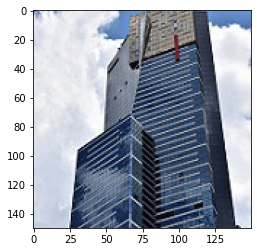

In [ ]:
transform = transforms.Compose([transforms.Resize((150,150)),
                                transforms.ToTensor()])
device = get_device()
print(device)

dataset = datasets.ImageFolder(train_dir, transform = transform)
test_set = datasets.ImageFolder(test_dir, transform = transform)
pred_set = datasets.ImageFolder(pred_dir, transform = transform)
# Get device for the training

print(test_set[0][0].shape)

# show an image of a test set
show_image(*test_set[0]) 



tensor([[[0.3529, 0.4431, 0.3922,  ..., 0.4353, 0.4392, 0.4392],
         [0.3333, 0.6078, 0.5490,  ..., 0.4118, 0.4157, 0.4157],
         [0.4980, 0.5373, 0.6118,  ..., 0.3961, 0.3961, 0.3961],
         ...,
         [0.7686, 0.7686, 0.7725,  ..., 0.8784, 0.8863, 0.8941],
         [0.7647, 0.7647, 0.7647,  ..., 0.8784, 0.8941, 0.9098],
         [0.7529, 0.7529, 0.7569,  ..., 0.8745, 0.9020, 0.9176]],

        [[0.4667, 0.5490, 0.4863,  ..., 0.5765, 0.5804, 0.5804],
         [0.4431, 0.7098, 0.6392,  ..., 0.5765, 0.5804, 0.5804],
         [0.6000, 0.6314, 0.6863,  ..., 0.5725, 0.5725, 0.5725],
         ...,
         [0.8157, 0.8157, 0.8078,  ..., 0.9020, 0.9137, 0.9216],
         [0.8078, 0.8078, 0.8078,  ..., 0.9020, 0.9216, 0.9373],
         [0.8039, 0.8039, 0.8078,  ..., 0.8980, 0.9294, 0.9451]],

        [[0.7020, 0.7647, 0.6588,  ..., 0.8039, 0.8078, 0.8078],
         [0.6392, 0.9020, 0.8039,  ..., 0.8118, 0.8157, 0.8157],
         [0.7294, 0.7725, 0.8431,  ..., 0.8039, 0.8039, 0.

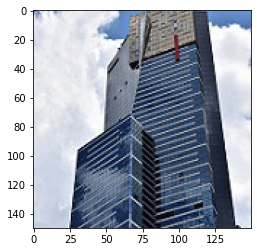

In [ ]:
print(test_set[0][0])
print(test_set[0][1])
plt.imshow(np.transpose(test_set[0][0],(1,2,0)))

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Number of training images is: 11947
Number of validating images is: 2108


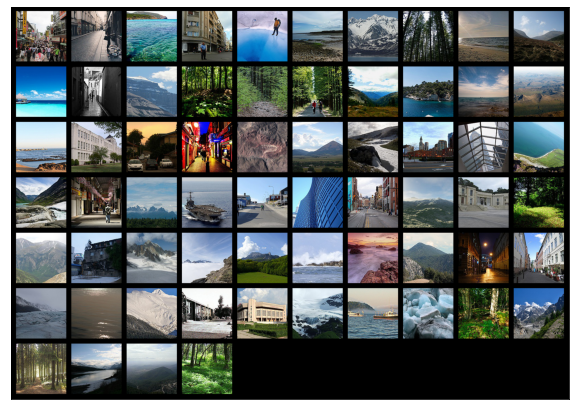

In [ ]:
#spliting dataset into training and validating 
train_indices, valid_indices = train_val_split_indices(len(dataset), 0.15)
print(dataset.class_to_idx)
print(f"""Number of training images is: {len(train_indices)}
Number of validating images is: {len(valid_indices)}""")

#Creating training loader
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(dataset, batch_size= 64, sampler= train_sampler)
#Creating validation loader
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_indices)
val_loader = torch.utils.data.DataLoader(dataset, batch_size= 64, sampler= val_sampler)
#show some training batch
show_batch_images(train_loader)

MODEL REPRESENTATION

In [ ]:
model = torchvision.models.resnet50(pretrained=True)
model.fc = nn.Linear(2048,6)
no_epochs = 25
lr = 0.001
# Move model to GPU
model = model.to(device)

# Initiate the loss function 
loss = nn.CrossEntropyLoss()

# Initiate the optimizer
optimizer = torch.optim.SGD

train_loss, val_loss, train_acc, val_acc = train_model(model, no_epochs, loss, train_loader, val_loader, optimizer, lr, metric= accuracy)





Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


PLOTTING VALIDATION AND TRAINING ACCURACY

In [ ]:
epochs = range(1, len(val_acc)+1)
plt.plot(epochs, train_acc, "g", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="validating accuracy")
plt.title("Training and Validation accuracy")
plt.xlabel("No of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

print("")
#loss value
plt.plot(epochs, train_loss, "g", label="Training loss")
plt.plot(epochs, val_loss, "b", label="validating loss")
plt.title("Training and Validation loss")
plt.xlabel("No of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

PREDICT SOME IMAGES FROM PREDICITON SET

In [ ]:
print(torch.cuda.device_count())

In [ ]:
#Test the accuracy
r = list(range(len(test_set)))
pred = 0
for i in r:
  test_image = test_set[i][0].unsqueeze(0).to(device)
  if dataset.classes[torch.argmax(nn.Softmax(dim=1)(model(test_image)))] == dataset.classes[test_set[i][1]]:
    pred = pred + 1
print("The accuracy on the test set is:", pred/len(test_set))

In [ ]:
# Randomize the index
r = list(range(len(pred_set)))
np.random.shuffle(r)
stop = 0

for i in r:
  image = pred_set[i][0].unsqueeze(0).to(device)
  print(stop+1)
  plt.imshow(pred_set[i][0].permute(1,2,0))
  plt.show()
  print("Prediction is:", dataset.classes[torch.argmax(nn.Softmax(dim=1)(model(image)))])
  stop += 1
  if stop == 10:
    break

CHECK THE PERFORMANCE OF THE MODEL ON TESTSET

In [ ]:
# Randomize the index
r = list(range(len(test_set)))
np.random.shuffle(r)
stop = 0

for i in r:
  print(stop + 1)
  show_image(*test_set[i])
  test_image = test_set[i][0].unsqueeze(0).to(device)
  print("Prediction is:", dataset.classes[torch.argmax(nn.Softmax(dim=1)(model(test_image)))])
  stop += 1
  if stop == 10: 
    break


In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 124, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    nn.Conv2d(124, 64,kernel_size=5, padding=2 ),
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    nn.Conv2d(64, 32,kernel_size=5, padding=2 ),
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    nn.Conv2d(32, 16,kernel_size=5, padding=2 ),
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    nn.Conv2d(16, 16,kernel_size=5, padding=2 ),
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    nn.Conv2d(16, 16,kernel_size=5, padding=2 ),
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    nn.Flatten(),
    nn.Linear(16,6),

    nn.Softmax()

   

    

)        

PROCESS VALIDATION DATASETS

**Results**


Accomplished figuring how to use the image classification architecture (provided to me through pytorch) and implemented the given training (+validation) data shared with me through https://www.kaggle.com/youssefalsoufi/cnn-for-image-classification.

Achieved a validation accuracy of 92 % after running parallel backpropagation gradient descent over a time period of x hours. 
What is further needed to be done: 
- plot the loss function given my produced features
- implement a distortion and modification software for the pre existing sample data to gather even for challenging images
To these efforts, I hope to improve the efficiency and accuracy of my prediction model while remaining it to not overfit if further training data is given.



